## <img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Part 3a - Modelling
- [Data Dictionary](#Data-Dictionary)
- [Modelling](#Modelling)

## Import Libraries

In [3]:
# Basic imports
import pandas as pd
import numpy as np
from numpy import arange


# Time
import time
from datetime import datetime

# Visualisation 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Data Processing 
import re
import string
import nltk


# Scikit-learn
from sklearn import ensemble, preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

# Vectorizing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling - Basics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

# Modelling - Classification metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import plot_roc_curve, roc_auc_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
pd.set_option('display.width', None)

## Load Data

In [4]:
df = pd.read_csv('../data/final_clean_df.csv')

In [5]:
df.head()

,vaers_id,age_yrs,sex,symptom_text,hospdays,recovd,numdays,v_adminby,other_meds,history,prior_vax,form_vers,er_ed_visit,allergies,vax_type,vax_manu,vax_dose_series,vax_route,vax_site,vax_name,serious,clean_symptom_text
0,916612.0,71.0,F,Left side of face became numb including to beh...,0.0,U,0.0,PVT,"levothyroxine 100mcg/day, estradiol 1mg/day",Graves Disease,NaN,2.0,0.0,"penicillin, toradol, methimazole",COVID19,MODERNA,0,IM,LA,COVID19 (COVID19 (MODERNA)),0,"['left', 'side', 'face', 'became', 'numb', 'in..."
1,916641.0,44.0,F,Vertigo every evening when lying down and ever...,0.0,N,0.0,PVT,"multivitamin, D3, baby aspirin",none,NaN,2.0,0.0,"latex, sulfa drugs",COVID19,MODERNA,0,IM,RA,COVID19 (COVID19 (MODERNA)),0,"['vertigo', 'every', 'evening', 'lying', 'ever..."
2,916702.0,70.0,F,body aches and stomach ache,0.0,N,31.0,PVT,Triamterene HCTZ Montelukast Celecoxib Aller-T...,asthma when I get a cold,NaN,2.0,0.0,too much cordosone,COVID19,MODERNA,0,SYR,UN,COVID19 (COVID19 (MODERNA)),0,"['body', 'ache', 'stomach', 'ache']"
3,917195.0,47.0,F,H a diarrhea SEVERE joint pain all through bo...,0.0,N,0.0,PVT,None,Serious episode of covid + 11/18/2020,NaN,2.0,0.0,None,COVID19,MODERNA,0,UN,RA,COVID19 (COVID19 (MODERNA)),0,"['h', 'diarrhea', 'severe', 'joint', 'pain', '..."
4,917195.0,47.0,F,H a diarrhea SEVERE joint pain all through bo...,0.0,N,0.0,PVT,None,Serious episode of covid + 11/18/2020,NaN,2.0,0.0,None,COVID19,MODERNA,0,UN,RA,COVID19 (COVID19 (MODERNA)),0,"['h', 'diarrhea', 'severe', 'joint', 'pain', '..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536690 entries, 0 to 536689
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   vaers_id            536690 non-null  float64
 1   age_yrs             536690 non-null  float64
 2   sex                 536690 non-null  object 
 3   symptom_text        536690 non-null  object 
 4   hospdays            536690 non-null  float64
 5   recovd              536690 non-null  object 
 6   numdays             536690 non-null  float64
 7   v_adminby           536690 non-null  object 
 8   other_meds          383513 non-null  object 
 9   history             380085 non-null  object 
 10  prior_vax           33754 non-null   object 
 11  form_vers           536690 non-null  float64
 12  er_ed_visit         536690 non-null  float64
 13  allergies           348819 non-null  object 
 14  vax_type            536690 non-null  object 
 15  vax_manu            536690 non-nul

## Data Dictionary

The following table describes the different features in the data. A guide of how to intepret the original dataset can also be found at the following [link](https://vaers.hhs.gov/docs/VAERSDataUseGuide_en_September2021.pdf).

| Feature | Type | Description |
|---:|---:|---:|
| symptom_text | object | Description of symptoms experienced by patient |
| serious | int | non-serious or serious |

In [9]:
# Look at split between categories
df['serious'].value_counts(normalize=True)

0    434899
1    101791
Name: serious, dtype: int64

### Splitting the Data

In [10]:
# Assign X & y
X = df['clean_symptom_text']
y = df['serious']

# Use test size of 90% as it represents around 50k rows of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.9, 
                                                    random_state=200, stratify=y)

# Modelling

#### Vectorization
* Count Vectorizer (CVEC)
* Term Frequency–Inverse Document Frequency Vectorizer (TFIDF)

#### Modelling
* Logistic Regression
* Naive Bayes - Multinomal
* Random Forest Classifier
* Ada Boost Classifier
* Support Vector Machine (SVM)

In [11]:
# Create empty results dataframe
df_results = pd.DataFrame(
    columns = [
        'Model No.',
        'Word Vectorizer',
        'Classifier',
        #'Cross-validated ROC AUC Score',
        'CV Score (train)',
        'Accuracy (train)',
        'Accuracy (test)',
        'Recall (test)', 
        'F1 score (test)',
        'Specificity (test)',
        'Precision (test)',
    ]
)

In [12]:
# Create function to run pipe and print results
def run_grid(X_train, X_test, y_train, y_test):

    
    # Instantiate GridSearchCV
    gs = GridSearchCV(
        pipe, 
        param_grid = params, 
        cv = 5,
        verbose = 1
    )

    # Fit model
    gs.fit(X_train, y_train)

    # Confusion matrix
    y_pred = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    plot_confusion_matrix(gs, 
                  X_test, y_test, 
                  cmap='RdPu', 
                  values_format='d',
                  display_labels=['non-serious', 'serious']
                 );

    
    # Find current length of df_results
    length = len(df_results)
    
    # Store results in new_row
    new_row = [{
        'Model No.' : length + 1,
        'Word Vectorizer' : pipe.steps[0][1],
        'Classifier' : pipe.steps[1][1],
        #'Cross-validated ROC AUC Score' : round(gs.roc_auc_score(X_test, y_test), 3),
        'CV Score (train)' : round(gs.best_score_, 3),
        'Accuracy (train)': round(gs.score(X_train, y_train), 3),
        'Accuracy (test)' : round(gs.score(X_test, y_test), 3),
        'Recall (test)' : round (tp/(tp+fn), 3), 
        'F1 score (test)': round((tp/(tp+(fp+fn)/2)), 3),
        'Specificity (test)' : round (tn/(tn+fp), 3),
        'Precision (test)' : round (tp/(tp+fp), 3),
    }]
    
    # Print best parameters from GridSearchCV
    print('Best Parameters:', gs.best_params_)
    
    return new_row

### Logistic Regression

Logistic regression is used to predict a dependent categorical variable, which is whether an AE is serious or not in our case. It uses a link function (known as the logit link) to effectively "bend" the line so that the curve of the best fit matches the values.

This model is easy to implement, interpret and efficient to train. However a major limitation is the assumption of linearity between dependent and independent variables.

The model will be tuned with GridSearchCV to optimise the hyperparameter 'C' which is the inverse of regularisation strength. Regularisation introduces a penalty to avoid overfitting of the model. The smaller the value of 'C', the stronger the regularisation.

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'cvec__max_features': 20000, 'cvec__min_df': 10, 'cvec__ngram_range': (2, 2), 'logit__C': 1}
CPU times: user 8min 38s, sys: 42.3 s, total: 9min 21s
Wall time: 6min 55s


Text(0.5, 1.0, 'CVEC Logistic Regression')

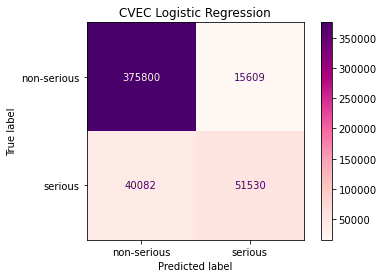

In [13]:
%%time

# Instantiate CountVectorizer() and LogisticRegressionCV()
cvec = CountVectorizer()
logit = LogisticRegression()

pipe = Pipeline([
    ('cvec', cvec),
    ('logit', logit)])

params = {
    'cvec__max_features': [5000, 10000, 20000],
    'cvec__ngram_range': [(2,2)], 
    'cvec__min_df': [10],
    #'cvec__ngram_range': [(1,1), (1,2), (1,3)],     
    'logit__C': [0.1, 1, 10],} 
    #'logit__penalty': ['l1', 'l2', 'none']}


new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC Logistic Regression');

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'logit__C': 10, 'tvec__max_features': 20000, 'tvec__min_df': 10, 'tvec__ngram_range': (2, 2)}
CPU times: user 8min 8s, sys: 36.5 s, total: 8min 44s
Wall time: 6min 30s


Text(0.5, 1.0, 'TVEC Logistic Regression')

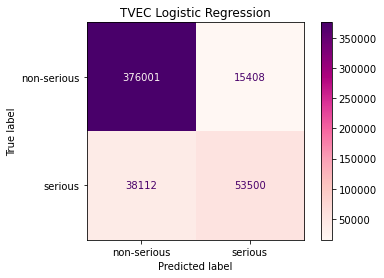

In [14]:
%%time

# Instantiate TfidfVectorizer() and LogisticRegressionCV()
tvec = TfidfVectorizer()
logit = LogisticRegression()

pipe = Pipeline([
    ('tvec', tvec),
    ('logit', logit)])

params = {
    'tvec__max_features': [5000, 10000, 20000],
    'tvec__ngram_range': [(2,2)],
    'tvec__min_df': [10],
    #'tvec__ngram_range': [(1,1), (1,2), (1,3)],    
    'logit__C': [0.1, 1, 10],} 
    #'logit__penalty': ['l1', 'l2', 'none']}


new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TVEC Logistic Regression');

In [15]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Recall (test),F1 score (test),Specificity (test),Precision (test)
0,1,CountVectorizer(),LogisticRegression(),0.883,0.950,0.885,0.562,0.649,0.960,0.768
0,2,TfidfVectorizer(),LogisticRegression(),0.887,0.948,0.889,0.584,0.667,0.961,0.776


**Observations:**

Both models have very close scores in all metrics, however tvec outperforms cvec in all metrics except accuracy (train). The accuracy has hit our target of 0.7 for accuracy but not the F1 score which should also be 0.7.


The accuracy score is the percentage of correctly predicted serious AE. The recall represents the fraction of correctly predicted serious AE with respect to all actual serious AE. A lower recall may be attributed to serious AE being misclassified as non-serious. The precision is defined by the fraction of predicted serious AE among all the predicted serious AE. A lower precision may indicate non-serious AE being misclassifed as serious. The F1 score gives the harmonic mean of precision and recall metrics, hence offering a better overall measure of performance as compared to just using precision or recall alone. 

With a score train accuracy score of > 0.9 and test accuracy score of > 0.8, it indicates that the model is able to correctly predict serious AE 90% in the train dataset and 80% in the test dataset. Since the difference between the train and test accuracy is lower for tvec model, it suggests that the vectorized words produced help to reduce overfitting. The F1 score of 0.6 represents the harmonic mean of recall (0.5) and precision (0.7) which suggests that the model more likely misclassifying serious AE as non-serious as compared to non-serious as serious.

### Multinomial Naive Bayes

Naive Bayes is based on Bayes theorem and predicts the likelihood that an event will occur given evidence that is present in the dataset. Multinomial Naive Bayes has been chosen as it is the most suitable when our variables are positive integers.

This model can work effectively well with large datasets and has relatively low computational costs. However, it assumes that all features are independent which is difficult to acquire in real life.

The model will be tuned with GridSearchCV to optimise the hyperparameter 'alpha' which represent the Laplace smoothing parameter and 'fit_prior' representing whether to learn class prior probabilities or not.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'cvec__max_features': 40000, 'cvec__min_df': 10, 'cvec__ngram_range': (2, 2), 'nb__alpha': 0.5, 'nb__fit_prior': True}
CPU times: user 6min 59s, sys: 5.46 s, total: 7min 5s
Wall time: 7min 8s


Text(0.5, 1.0, 'CVEC Naive Bayes')

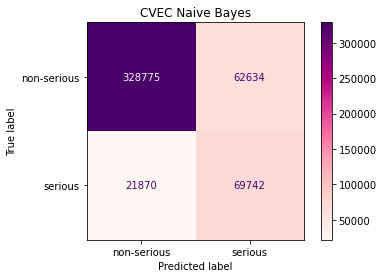

In [16]:
%%time

# Instantiate CountVectorizer() and MultinomialNB()
cvec = CountVectorizer()
nb = MultinomialNB()

pipe = Pipeline([
    ('cvec', cvec),
    ('nb', nb)])

params = {
    'cvec__max_features': [10000, 20000, 40000],
    'cvec__ngram_range': [(2,2)], 
    'cvec__min_df': [10],
    'nb__alpha': np.linspace(0.5, 1.5, 2),
    'nb__fit_prior': [True, False]
}

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC Naive Bayes');

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'nb__alpha': 1.5, 'nb__fit_prior': True, 'tvec__max_features': 40000, 'tvec__min_df': 10, 'tvec__ngram_range': (2, 2)}
CPU times: user 6min 54s, sys: 4.71 s, total: 6min 59s
Wall time: 7min


Text(0.5, 1.0, 'TF-IDF Naive Bayes')

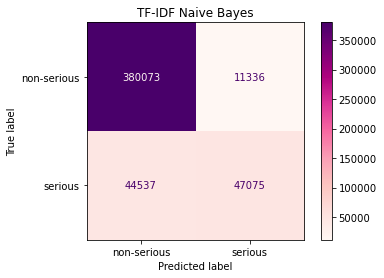

In [17]:
%%time

# Instantiate TfidfVectorizer() and MultinomialNB()
tvec = TfidfVectorizer()
nb = MultinomialNB()

pipe = Pipeline([
    ('tvec', tvec),
    ('nb', nb)
])

params = {
    'tvec__max_features': [10000, 20000, 40000],
    'tvec__ngram_range': [(2,2)], 
    'tvec__min_df': [10],
    'nb__alpha': np.linspace(0.5, 1.5, 2),
    'nb__fit_prior': [True, False]}

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TF-IDF Naive Bayes');

In [18]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Recall (test),F1 score (test),Specificity (test),Precision (test)
0,1,CountVectorizer(),LogisticRegression(),0.883,0.950,0.885,0.562,0.649,0.960,0.768
0,2,TfidfVectorizer(),LogisticRegression(),0.887,0.948,0.889,0.584,0.667,0.961,0.776
0,3,CountVectorizer(),MultinomialNB(),0.823,0.847,0.825,0.761,0.623,0.840,0.527
0,4,TfidfVectorizer(),MultinomialNB(),0.882,0.899,0.884,0.514,0.628,0.971,0.806


**Observations:**

Multinomial Naive Bayes has hit our target of 0.7 for accuracy but not the F1 score which should also be 0.7.

With a score accuracy score of > 0.8 for train and test indicates that the model is able to correctly predict serious AE 80% in both datasets. Since the difference between the train and test accuracy is lower for tvec model, it suggests that the vectorized words produced help to reduce overfitting. The F1 score of 0.6 represents the model more likely misclassifying serious AE as non-serious as compared to non-serious as serious.

### Random Forest Classifier

Random Forest uses an ensemble of decision trees to take the most popular category of trees in the esemble. This model uses a variant of bagging, also known as bootstrap aggregating which selects a random replacement of training set and fit trees. Random Forest correct for decision trees' habit of overfitting to training set, thus bringing down variance due to averaging.

Random Forest is highly flexible and gives a good accuracy while working well on large datasets. However, the tradeoff is that this model is computationally expensive.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'cvec__max_features': 5000, 'cvec__min_df': 10, 'cvec__ngram_range': (2, 2)}
CPU times: user 12min 46s, sys: 4.18 s, total: 12min 50s
Wall time: 12min 54s


Text(0.5, 1.0, 'CVEC and Random Forest Classifier')

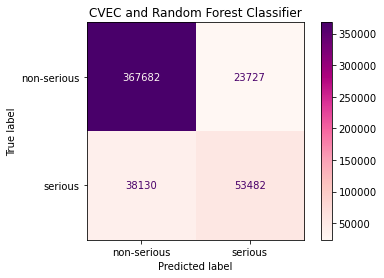

In [19]:
%%time

# Instantiate CountVectorizer() and RandomForestClassifier()
cvec = CountVectorizer()
rfc = RandomForestClassifier()

pipe = Pipeline([
    ('cvec', cvec),
    ('rfc', rfc)])

params = {
    'cvec__max_features': [5000],
    'cvec__ngram_range': [(2,2)], 
    'cvec__min_df': [10],}  
    #'rfc__n_estimators': [10, 100, 500]} 

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC and Random Forest Classifier');

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'tvec__max_features': 5000, 'tvec__min_df': 10, 'tvec__ngram_range': (2, 2)}
CPU times: user 15min 39s, sys: 5.29 s, total: 15min 44s
Wall time: 15min 50s


Text(0.5, 1.0, 'TVEC and Random Forest Classifier')

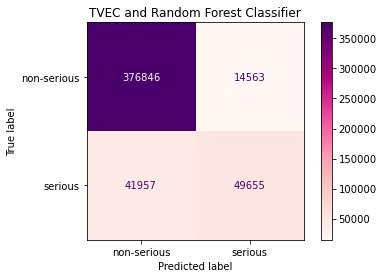

In [20]:
%%time

# Instantiate TfidfVectorizer() and RandomForestClassifier()
tvec = TfidfVectorizer()
rfc = RandomForestClassifier()

pipe = Pipeline([
    ('tvec', tvec),
    ('rfc', rfc)])

params = {
    'tvec__max_features': [5000],
    'tvec__ngram_range': [(2,2)], 
    'tvec__min_df': [10],}
    #'tvec__ngram_range': [(1,1), (1,2), (1,3)],    
    #'rfc__n_estimators': [10, 100, 500],} 

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TVEC and Random Forest Classifier');

In [21]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Recall (test),F1 score (test),Specificity (test),Precision (test)
0,1,CountVectorizer(),LogisticRegression(),0.883,0.950,0.885,0.562,0.649,0.960,0.768
0,2,TfidfVectorizer(),LogisticRegression(),0.887,0.948,0.889,0.584,0.667,0.961,0.776
0,3,CountVectorizer(),MultinomialNB(),0.823,0.847,0.825,0.761,0.623,0.840,0.527
0,4,TfidfVectorizer(),MultinomialNB(),0.882,0.899,0.884,0.514,0.628,0.971,0.806
0,5,CountVectorizer(),RandomForestClassifier(),0.871,0.980,0.872,0.584,0.634,0.939,0.693
0,6,TfidfVectorizer(),RandomForestClassifier(),0.881,0.980,0.883,0.542,0.637,0.963,0.773


**Observations:**

Random Forest Classifier has hit our target of 0.7 for accuracy but not the F1 score which should also be 0.7.

With a score train accuracy score of > 0.9 and test accuracy score of > 0.8, it indicates that the model is able to correctly predict serious AE 90% in the train dataset and 80% in the test dataset. With the highest train accuracy out of all the models thus far, it suggests that the rfc is highly fitted to the train model. As seen from  the difference between the train and test accuracy being the greatest so far, it seems that the model is highly overfitted to the train data as compared to the prior models. We also find the tvec with a higher test accuracy score, indicating it is less overfitted as compared to the model using cvec as a vectorizer.

The F1 score of 0.6 represents the model more likely misclassifying serious AE as non-serious as compared to non-serious as serious.

### Ada Boost Classifier

AdaBoost, short for Adaptive Boosting, helps to combine weak classifiers into a single strong classifier. The weak learners are decision trees with single splits, called decision stumps. 

The default parameters will be used for modelling.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'cvec__max_features': 5000, 'cvec__min_df': 10, 'cvec__ngram_range': (2, 2)}
CPU times: user 2min 44s, sys: 1.67 s, total: 2min 46s
Wall time: 2min 47s


Text(0.5, 1.0, 'CVEC and Ada Boost Classifier')

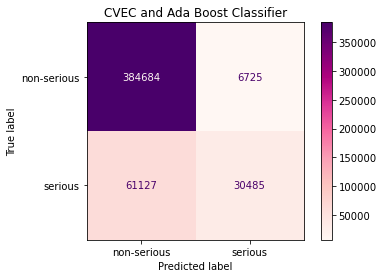

In [22]:
%%time

# Instantiate CountVectorizer() and AdaBoostClassifier()
cvec = CountVectorizer()
ada = AdaBoostClassifier()

pipe = Pipeline([
    ('cvec', cvec),
    ('ada', ada)])

params = {
    'cvec__max_features': [5000],
    'cvec__ngram_range': [(2,2)], 
    'cvec__min_df': [10]}  

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC and Ada Boost Classifier');

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'tvec__max_features': 5000, 'tvec__min_df': 10, 'tvec__ngram_range': (2, 2)}
CPU times: user 3min 14s, sys: 2.15 s, total: 3min 16s
Wall time: 3min 18s


Text(0.5, 1.0, 'TVEC and Ada Boost Classifier')

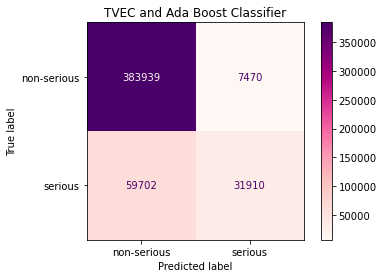

In [23]:
%%time

# Instantiate TfidfVectorizer() and AdaBoostClassifier()
tvec = TfidfVectorizer() 
ada = AdaBoostClassifier()

pipe = Pipeline([
    ('tvec', tvec),
    ('ada', ada)])

params = {
    'tvec__max_features': [5000],
    'tvec__ngram_range': [(2,2)], 
    'tvec__min_df': [10]}  

new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TVEC and Ada Boost Classifier');

In [24]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Recall (test),F1 score (test),Specificity (test),Precision (test)
0,1,CountVectorizer(),LogisticRegression(),0.883,0.950,0.885,0.562,0.649,0.960,0.768
0,2,TfidfVectorizer(),LogisticRegression(),0.887,0.948,0.889,0.584,0.667,0.961,0.776
0,3,CountVectorizer(),MultinomialNB(),0.823,0.847,0.825,0.761,0.623,0.840,0.527
0,4,TfidfVectorizer(),MultinomialNB(),0.882,0.899,0.884,0.514,0.628,0.971,0.806
0,5,CountVectorizer(),RandomForestClassifier(),0.871,0.980,0.872,0.584,0.634,0.939,0.693
0,6,TfidfVectorizer(),RandomForestClassifier(),0.881,0.980,0.883,0.542,0.637,0.963,0.773
0,7,CountVectorizer(),AdaBoostClassifier(),0.861,0.861,0.860,0.333,0.473,0.983,0.819
0,8,TfidfVectorizer(),AdaBoostClassifier(),0.861,0.865,0.861,0.348,0.487,0.981,0.810


**Observations:**

Ada Boost Classifer has hit our target of 0.7 for accuracy but not the F1 score which should also be 0.7.

It has a relative decent train and test accuracy score at 0.8, however it has the most dismal F1 score at 0.4 suggesting that while the model may be predicting serious AE correctly, it is also vastly misclassifying both serious AE as non-serious and vice versa.

### Support Vector Machines (SVM)

SVM is a classifer that finds an optimal hyperplane that maximises margin between 2 classes of data. It uses the kernel trick which transforms data that is not linearly seperable in n-dimension space to a higher dimension where it is linearly separable.

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'cvec__max_features': 5000, 'cvec__min_df': 10, 'cvec__ngram_range': (2, 2), 'svc__C': 10, 'svc__degree': 2, 'svc__kernel': 'poly'}
CPU times: user 7h 40min 50s, sys: 1min 54s, total: 7h 42min 44s
Wall time: 7h 48min 25s


Text(0.5, 1.0, 'CVEC and SVC')

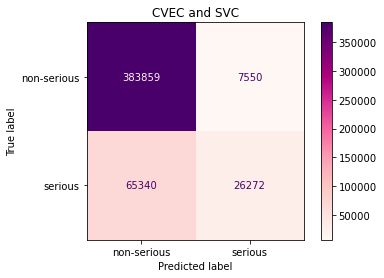

In [25]:
%%time

# Instantiate CountVectorizer() and SVC()
cvec = CountVectorizer()
svc = SVC()

pipe = Pipeline([
    ('cvec', cvec),
    ('svc', svc)])

params = {
    'cvec__max_features': [5000, 10000, 20000],
    'cvec__ngram_range': [(2,2)],
    'cvec__min_df': [10],
    #'tvec__ngram_range': [(1,1), (1,2), (1,3)],    
    'svc__C': [0.1, 1, 10], 
    'svc__kernel': ['poly'], 
    'svc__degree': [2]}



new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('CVEC and SVC');

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'svc__C': 1, 'svc__degree': 2, 'svc__kernel': 'poly', 'tvec__max_features': 10000, 'tvec__min_df': 10, 'tvec__ngram_range': (2, 2)}
CPU times: user 7h 36min 9s, sys: 1min 11s, total: 7h 37min 20s
Wall time: 7h 38min


Text(0.5, 1.0, 'TVEC and SVC')

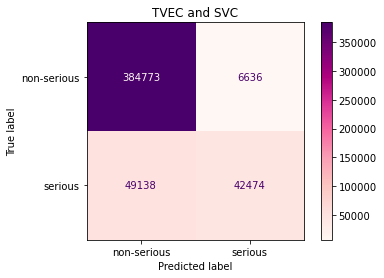

In [26]:
%%time

# Instantiate TfidfVectorizer() and SVC()
tvec = TfidfVectorizer()
svc = SVC()

pipe = Pipeline([
    ('tvec', tvec),
    ('svc', svc)])

params = {
    'tvec__max_features': [5000, 10000, 20000],
    'tvec__ngram_range': [(2,2)], 
    'tvec__min_df': [10],
    #'tvec__ngram_range': [(1,1), (1,2), (1,3)],    
    'svc__C': [0.1, 1, 10], 
    'svc__kernel': ['poly'], 
    'svc__degree': [2]}


new_results = run_grid(X_train, X_test, y_train, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
plt.title('TVEC and SVC');

In [27]:
df_results

,Model No.,Word Vectorizer,Classifier,CV Score (train),Accuracy (train),Accuracy (test),Recall (test),F1 score (test),Specificity (test),Precision (test)
0,1,CountVectorizer(),LogisticRegression(),0.883,0.950,0.885,0.562,0.649,0.960,0.768
0,2,TfidfVectorizer(),LogisticRegression(),0.887,0.948,0.889,0.584,0.667,0.961,0.776
0,3,CountVectorizer(),MultinomialNB(),0.823,0.847,0.825,0.761,0.623,0.840,0.527
0,4,TfidfVectorizer(),MultinomialNB(),0.882,0.899,0.884,0.514,0.628,0.971,0.806
0,5,CountVectorizer(),RandomForestClassifier(),0.871,0.980,0.872,0.584,0.634,0.939,0.693
0,6,TfidfVectorizer(),RandomForestClassifier(),0.881,0.980,0.883,0.542,0.637,0.963,0.773
0,7,CountVectorizer(),AdaBoostClassifier(),0.861,0.861,0.860,0.333,0.473,0.983,0.819
0,8,TfidfVectorizer(),AdaBoostClassifier(),0.861,0.865,0.861,0.348,0.487,0.981,0.810
0,9,CountVectorizer(),SVC(),0.846,0.896,0.849,0.287,0.419,0.981,0.777
0,10,TfidfVectorizer(),SVC(),0.881,0.971,0.885,0.464,0.604,0.983,0.865


**Observations:**

SVM has hit our target of 0.7 for accuracy but not the F1 score which should also be 0.7.

The model has a decent train accuracy score of > 0.9 and test accuracy score of > 0.8, however it has a dismal F1 score at 0.6 with recall hovering from 0.2-0.4 suggesting that while the model may be less likely to misclassify non-serious AE, is it severely misclassifying serious AE.

#### Final thoughts on first round of modelling:
Of all the models, Logistic Regression with TF-IDF vectorizer has the most balanced performance with a train accuracy of 0.948, test accuracy of 0.899 and F1 score of 0.667. Though it does not have the highest train accuracy, it does have one of the lowest train-test accuracy indicating less overfitting compared to the other models, and the highest F1 score indicating a good harmonized mean of precision and recall.

For our next iteration, we will try to use SMOTE to tackle the imbalance dataset.